In [80]:
#initial version
#created on 24.11.2020
#Inspired by https://www.kaggle.com/furiousx7/xgboost-time-series
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold


train_data = pd.read_csv('../Data/Train_Plant2.csv')



In [81]:
def create_features(in_data):
    in_data['DATE_TIME'] = pd.to_datetime(in_data['DATE_TIME'])
    in_data["DATE"] = in_data['DATE_TIME'].dt.date
    in_data["HOUR"] = in_data['DATE_TIME'].dt.hour
    in_data["MINUTE"] = in_data['DATE_TIME'].dt.minute
    in_data["DAY_OF_YEAR"] = in_data['DATE_TIME'].dt.dayofyear
    in_data["DAY_OF_WEEK"] = in_data['DATE_TIME'].dt.dayofweek
    in_data["MONTH"] = in_data['DATE_TIME'].dt.month
    in_data["DAY_OF_MONTH"] = in_data['DATE_TIME'].dt.day

In [82]:
create_features(train_data)
train_columns = ['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
grouped_data = train_data.groupby(train_columns)[['DC_POWER','AC_POWER']].agg({'DC_POWER':'sum','AC_POWER':'sum'}).reset_index()
split_date = pd.to_datetime('06-01-2020')
pred_train = grouped_data.loc[grouped_data.DATE <= split_date].copy()
pred_test = grouped_data.loc[grouped_data.DATE > split_date].copy()
print( pred_train.shape,pred_test.shape)

(1728, 10) (720, 10)


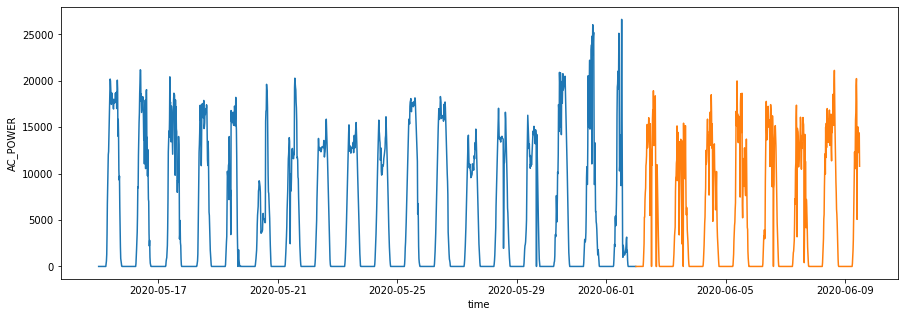

In [83]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('AC_POWER')
plt.plot(pred_train["DATE_TIME"],pred_train.DC_POWER)
plt.plot(pred_test["DATE_TIME"],pred_test.DC_POWER)
plt.show()

In [84]:
train_features = ['HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
predict_column = 'AC_POWER'
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(pred_train[train_features], pred_train[predict_column],
        eval_set=[(pred_train[train_features], pred_train[predict_column]), (pred_test[train_features], pred_test[predict_column])],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)

[0]	validation_0-rmse:6194.94385	validation_1-rmse:5994.82666
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4653.93799	validation_1-rmse:5008.35742
[2]	validation_0-rmse:3635.06201	validation_1-rmse:4202.94434
[3]	validation_0-rmse:2933.18726	validation_1-rmse:3744.15381
[4]	validation_0-rmse:2516.03149	validation_1-rmse:3394.21533
[5]	validation_0-rmse:2263.94751	validation_1-rmse:3255.03662
[6]	validation_0-rmse:2046.86755	validation_1-rmse:3450.22778
[7]	validation_0-rmse:1877.96936	validation_1-rmse:3442.33228
[8]	validation_0-rmse:1797.60364	validation_1-rmse:3378.90820
[9]	validation_0-rmse:1702.18225	validation_1-rmse:3419.40601
[10]	validation_0-rmse:1595.28723	validation_1-rmse:3623.73364
[11]	validation_0-rmse:1502.63648	validation_1-rmse:3621.66211
[12]	validation_0-rmse:1466.47754	validation_1-rmse:3684.44092
[13]	validation_0-rmse:1388.2023

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

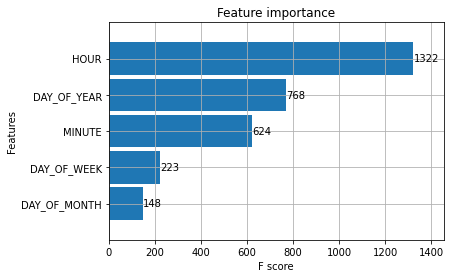

In [85]:
xgb.plot_importance(reg, height=0.9)

In [86]:
def plot_performance(base_data, date_from, date_to, test_data, test_predictions, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('energy consumed')
    plt.plot(base_data['DATE_TIME'],base_data[predict_column], label='data')
    plt.plot(test_data['DATE_TIME'], test_predictions, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)



1420.9333333333332

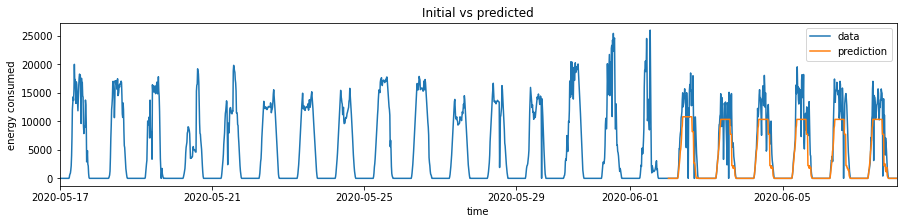

In [87]:
import datetime
pred_test_pred = reg.predict(pred_test[train_features])
plot_performance(grouped_data, datetime.datetime(2020,5,17) ,datetime.datetime(2020,6,8), pred_test, pred_test_pred,'Initial vs predicted')
plt.legend()
plt.show()


In [88]:
test_data = pd.read_csv('../Data/Test_Plant2.csv')
create_features(test_data)
grouped_test_data = test_data.groupby(['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH'])[['DC_POWER','AC_POWER']].agg({'DC_POWER':'sum','AC_POWER':'sum'}).reset_index()
test_data_predictions = reg.predict(grouped_test_data[train_features])
test_mse = mean_squared_error(y_true=grouped_test_data[predict_column],
                   y_pred=test_data_predictions)
print('MSE:',test_mse)

MSE: 7587490.2160179755


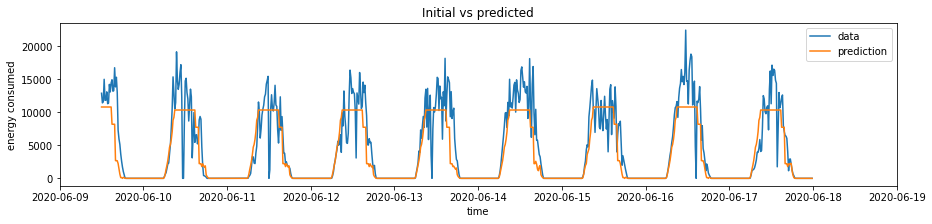

In [89]:
plot_performance(grouped_test_data, datetime.datetime(2020,6,9) ,datetime.datetime(2020,6,19),grouped_test_data,test_data_predictions,'Initial vs predicted')


Plant 2
Test run on 24.11.2020 22:06
Features:
['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
Predicted:
DC_POWER
MSE: 7903842.492750986

Plant 2
Test run on 24.11.2020 22:06
Features:
['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
Predicted:
AC_POWER
MSE: 7587490.2160179755

Plant 1
Test run on 24.11.2020 22:06
Features:
['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
Predicted:
DC_POWER
['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
MSE: 5724627891.190206

Plant 1
Test run on 24.11.2020 22:16
Features:
['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
Predicted:
AC_POWER
['DATE_TIME','DATE','HOUR','MINUTE','DAY_OF_YEAR','DAY_OF_WEEK','MONTH','DAY_OF_MONTH']
MSE: 53841742.44934202